In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [28]:
def create_dataset(base_path):
    dd = {"images": [], "labels": []}
    
    for i in os.listdir(base_path):
        label = i.strip().split()[0]
        print(label)
        label_dir = os.path.join(base_path, i)
        for j in os.listdir(label_dir):
            dd["images"] += [os.path.join(label_dir, j)]
            dd["labels"] += [label]
    
    return pd.DataFrame(dd)

In [30]:
base_path = "/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset"

df = create_dataset(base_path)

Male
Female


In [31]:
label_index = {"Male": 0,
              "Female": 1}

index_label = {0: "Male",
              1: "Female"}

df["labels"] = df["labels"].map(label_index)

In [32]:
df

images  labels
0     /kaggle/input/male-and-female-faces-dataset/Ma...       0
1     /kaggle/input/male-and-female-faces-dataset/Ma...       0
2     /kaggle/input/male-and-female-faces-dataset/Ma...       0
3     /kaggle/input/male-and-female-faces-dataset/Ma...       0
4     /kaggle/input/male-and-female-faces-dataset/Ma...       0
...                                                 ...     ...
5413  /kaggle/input/male-and-female-faces-dataset/Ma...       1
5414  /kaggle/input/male-and-female-faces-dataset/Ma...       1
5415  /kaggle/input/male-and-female-faces-dataset/Ma...       1
5416  /kaggle/input/male-and-female-faces-dataset/Ma...       1
5417  /kaggle/input/male-and-female-faces-dataset/Ma...       1

[5418 rows x 2 columns]

In [33]:
model_name = "mobilenetv2-035-128"

#NOTICE HOW WE ARE USING FEATURE VECTOR FOR THIS STEP AND NOT CLASSIFIER
model_handle_map = {
  "mobilenetv2-035-128": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 128)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 4

Selected model: mobilenetv2-035-128 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/2
Input size (128, 128)


In [ ]:
images_path_male = '/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Male Faces'
images_path_female = '/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Female Faces'

labels_df = df
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('male', 'female')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []
for image in labels_df.iloc:
#     print(images_path_male + image[0])
    images.append(np.asarray(cv2.resize(cv2.imread(image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
#     images.append(np.asarray(cv2.resize(cv2.imread(images_path_female + image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))

    # labels will be in the form of a vector: [0, 1] or [1, 0]
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

In [39]:
print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')


labels shape: (5418, 2)
images shape: (5418, 128, 128, 3)


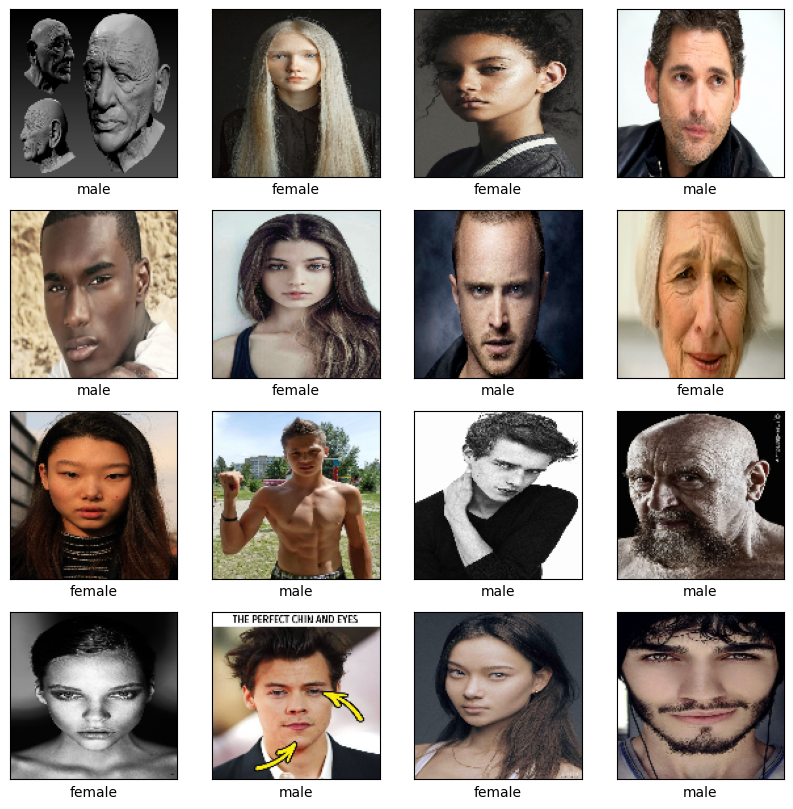

In [40]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images)-1)

        axs[x][y].imshow(images[i])

        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()

In [41]:
# DEFINE TRAIN/TEST SPLIT
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.4, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (3250, 128, 128, 3)
train labels shape: (3250, 2)

validation images shape: (2168, 128, 128, 3)
validation labels shape: (2168, 2)



In [42]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True,
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True,
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

In [45]:
do_fine_tuning = False

print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer(model_handle, trainable=do_fine_tuning)(x)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 1001)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1001)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,004 (7.83 KB)

 Trainable params: 2,004 (7.83 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}.keras')

In [49]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

train_size = X_train.shape[0]
valid_size = X_val.shape[0]
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_images_generator,
    epochs=5,
    verbose=1,
    validation_data=validation_images_generator, callbacks=[checkpoint_callback])

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 427ms/step - accuracy: 0.5649 - loss: 0.9732 - val_accuracy: 0.7011 - val_loss: 0.6153
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 379ms/step - accuracy: 0.6243 - loss: 0.7896 - val_accuracy: 0.7039 - val_loss: 0.6006
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 396ms/step - accuracy: 0.6490 - loss: 0.7189 - val_accuracy: 0.6868 - val_loss: 0.6604
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 375ms/step - accuracy: 0.6503 - loss: 0.7088 - val_accuracy: 0.7256 - val_loss: 0.5884
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 378ms/step - accuracy: 0.6773 - loss: 0.6725 - val_accuracy: 0.7080 - val_loss: 0.6060


In [50]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

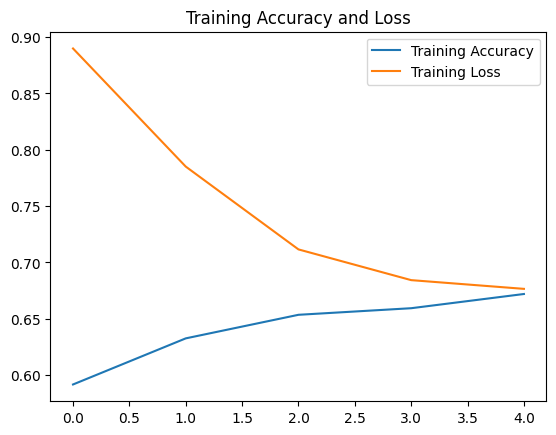

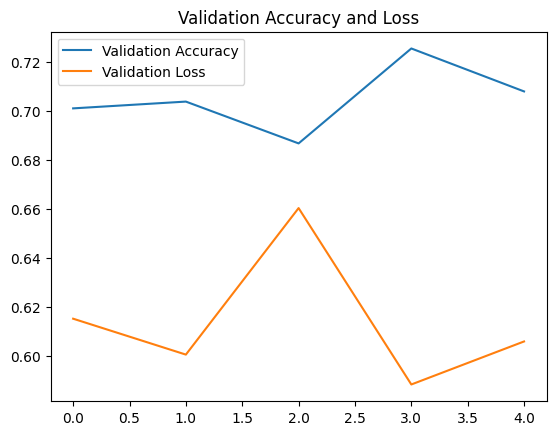

In [51]:
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

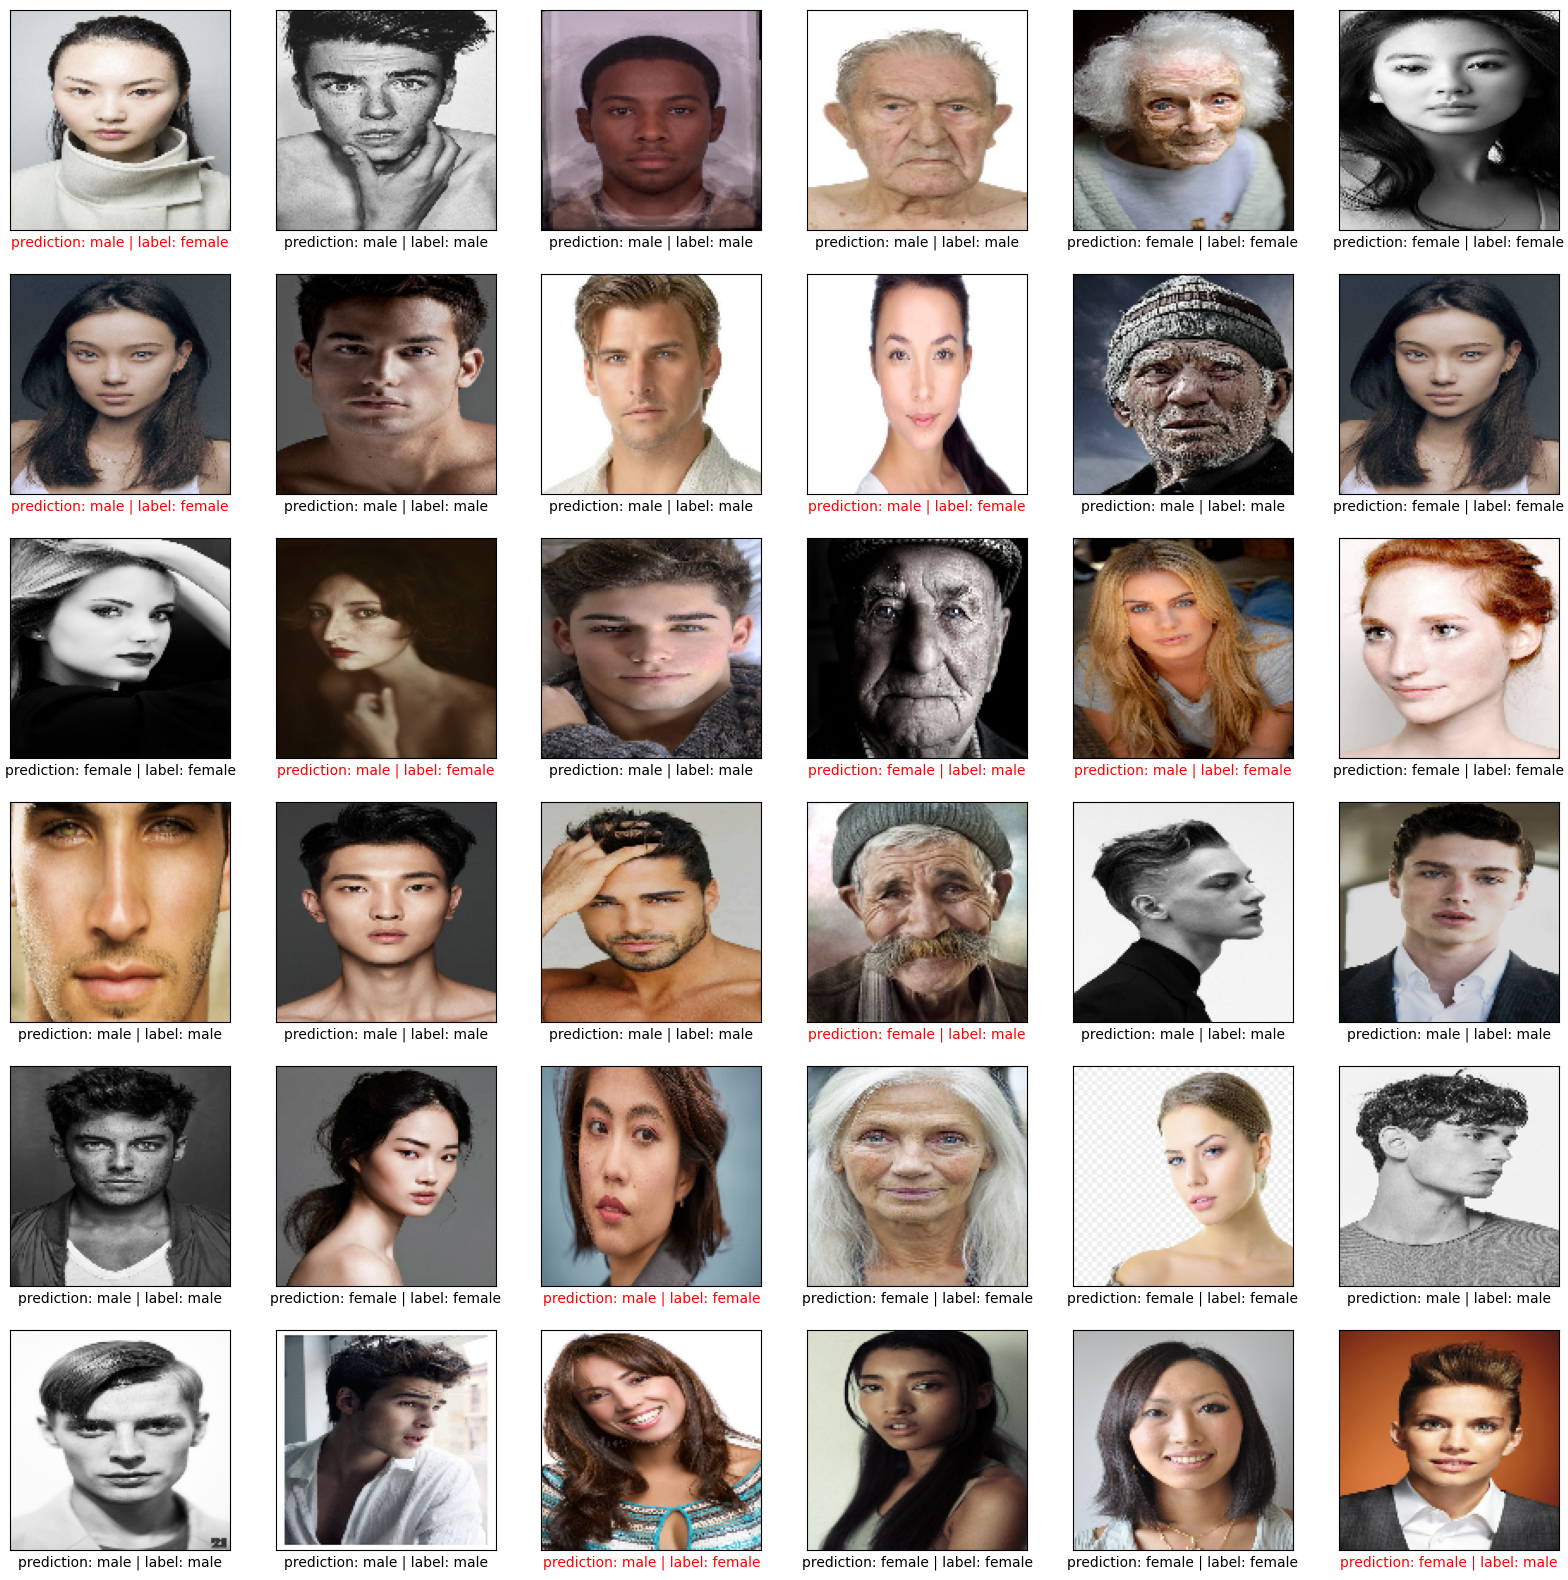

In [59]:
row, col = 6, 6

fig, axs = plt.subplots(row, col, figsize=(20, 20))

i = 0
for x in range(row):
    for y in range(col):
        prediction = model.predict(X_val[i][None, ...], verbose=0)[0]

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])

        if np.argmax(prediction) != np.argmax(y_val[i]):
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}', color='red')
        else:
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()